In [1]:
import pandas as pd
from tables import *
import numpy as np
from tqdm import tqdm_notebook as tqdm
import csv
from scipy import sparse
import pickle
import os
from matplotlib import pyplot as plt

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
min_year = 1980
max_year = 2019
nb_years = max_year-min_year

In [4]:
disciplines = pd.read_csv(path+'liste_discipline.txt',encoding='latin_1',sep='\t')
list_disciplines = pd.unique(disciplines['EDiscipline'])
nb_disciplines = len(list_disciplines)

In [5]:
types_cit = ['self','co','others']

In [6]:
authors_info = {}
with open(path+'model/authors_infos_model.csv','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        authors_info[int(line[0])] = [line[1],int(line[2]),int(line[4]),int(line[3])]

In [7]:
#Map to auth ID
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx_raw = pickle.load(f)

In [8]:
for disc in list_disciplines:
    authors_disc_idx_raw[disc] = {authors_disc_idx_raw[disc][x]:x for x in authors_disc_idx_raw[disc]}

In [9]:
plot_years = [0,1,2,3,4,5]

references = {}
citations = {}
for type_cit in types_cit:
    with open('{}/arrays/references_{}_array.p'.format(path,type_cit),'rb') as f:
        references[type_cit] = pickle.load(f)
    if not type_cit == 'others':
        with open('{}/arrays/citations_{}_array.p'.format(path,type_cit),'rb') as f:
            citations[type_cit] = pickle.load(f)


citations['others'] = {}
for disc in list_disciplines:
    with open('{}/arrays/citations_{}_{}_array.p'.format(path,'others',disc),'rb') as f:
        citations['others'][disc] = pickle.load(f)

for type_cit in types_cit:
    for disc in list_disciplines:
        references[type_cit][disc] = sparse.csr_matrix(references[type_cit][disc])
        citations[type_cit][disc] = sparse.csr_matrix(citations[type_cit][disc])

references = {}
citations = {}
for type_cit in types_cit:
    for disc in list_disciplines:
        sparse.save_npz('{}/sparse_arrays/citations_{}_{}_array.p'.format(path,type_cit,disc),citations[type_cit][disc])
        sparse.save_npz('{}/sparse_arrays/references_{}_{}_array.p'.format(path,type_cit,disc),references[type_cit][disc])

### Proportion of citations

In [10]:
for i in tqdm(range(nb_disciplines)):
    disc = list_disciplines[i]
    arrays_refs = {}
    arrays_cits = {}
    for type_cit in types_cit:
        arrays_cits[type_cit] = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
        arrays_refs[type_cit] = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
    arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    total_refs_cumul = np.sum(total_refs,axis=1)
    total_cits_cumul = np.sum(total_cits,axis=1)
    rows_refs = np.where(total_refs_cumul)[0]
    rows_cits = np.where(total_cits_cumul)[0]

    plot_types = ['self','co','self_net']
    stats_refs = {}
    stats_cits = {}

    keys = list(authors_disc_idx[disc])
    keys.sort()
    auth_idx_disc = [authors_disc_idx[disc][idx] for idx in keys]
    year_start = [authors_info[ID][1] for ID in auth_idx_disc]

    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
        arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

        idx_cits = total_cits.nonzero()
        idx_refs = total_refs.nonzero()
        arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
        arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

        count_cits = np.count_nonzero(total_cits,axis=1)
        idx_count_cits = np.where(count_cits)[0]
        #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_cits)
        for j in range(nb_authors):
            idx_author = idx_count_cits[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_cits[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1    
        
        stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_cits = total.nonzero()
        stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])

        count_refs = np.count_nonzero(total_refs,axis=1)
        idx_count_refs = np.where(count_refs)[0]
        #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_refs)
        
        for j in range(nb_authors):
            idx_author = idx_count_refs[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_refs[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1  

        stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_refs = total.nonzero()
        stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])


#     arrays_cits['self_net_perc_year'] = np.zeros(arrays_cits['self_net'].shape) 
#     idx_cits = total_cits.nonzero()
#     arrays_cits['self_net_perc_year'][idx_cits] = (arrays_cits['self_net'][idx_cits]/total_cits[idx_cits])*100
#     count_cits = np.count_nonzero(total_cits,axis=1)
#     idx_count_cits = np.where(count_cits)[0]
#     numerator = np.zeros((nb_years,nb_years))
#     total = np.zeros((nb_years,nb_years))
#     nb_authors = len(idx_count_cits)
#     for j in range(nb_authors):
#         idx_author = idx_count_cits[j]
#         year = year_start[idx_author]
#         if year >= min_year and year < max_year:
#             row_start = year - min_year
#             row = arrays_cits['self_net_perc_year'][idx_author,:]
#             numerator[:,row_start] += row
#             row_has_count = total_cits[idx_author,:].nonzero()[1]
#             total[row_has_count,row_start] += 1    
            
#     stats_cits['self_net_perc_year'] = np.zeros((nb_years,nb_years))
#     non_zero_cits = total.nonzero()
#     stats_cits['self_net_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])



    plt.figure(figsize=(30,15))
    n_yt = 5
    n_xt = 5
    xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
    yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
    #yticks_lab = np.round(yticks_lab,1)
    xticks = np.linspace(0,nb_years,n_xt)
    yticks = np.linspace(0,nb_years,n_yt)
    
    plt.subplot(231)
    plt.pcolor(stats_cits['self_perc_year'],cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Direct citations: ' + disc,fontsize=25)

    plt.subplot(232)
    plt.pcolor(stats_cits['co_perc_year'],cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Indirect citations: ' + disc,fontsize=25)
    
    plt.subplot(233)
    plt.pcolor(stats_cits['self_net_perc_year'],cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Network citations: ' + disc,fontsize=25)
    
    #Show var
    plt.subplot(234)
    plt.pcolor(stats_refs['self_perc_year'],cmap='bwr')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Direct references: ' + disc,fontsize=25)
    
    #Show var
    plt.subplot(235)
    plt.pcolor(stats_refs['co_perc_year'],cmap='bwr')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Indirect references: ' + disc,fontsize=25)

    plt.subplot(236)
    plt.pcolor(stats_refs['self_net_perc_year'],cmap='bwr')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Network references: ' + disc,fontsize=25)

    
    
    out_path = path+'results/fig_matrix_norm_perc_network/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + disc + '.png')
    plt.close()
    
    plt.figure(figsize=(12,8))
    for j in plot_years:
        xaxis = np.arange(min_year,max_year-j)
        nb_x = len(xaxis)
        idx_year = plot_years[j]
        plt.subplot(2,3,j+1)
        plt.plot(xaxis,stats_cits['self_perc_year'][idx_year,:nb_x],'r',label='% direct cits')
        plt.plot(xaxis,stats_cits['co_perc_year'][idx_year,:nb_x],'r--',label='% indirect cits')
        plt.plot(xaxis,stats_cits['self_net_perc_year'][idx_year,:nb_x],'r-.',label='% network cits')
        plt.plot(xaxis,stats_refs['self_perc_year'][idx_year,:nb_x],'g',label='% direct refs')
        plt.plot(xaxis,stats_refs['co_perc_year'][idx_year,:nb_x],'g--',label='% indirect refs')
        plt.plot(xaxis,stats_refs['self_net_perc_year'][idx_year,:nb_x],'g-.',label='% network refs')
        plt.xlim([min_year,max_year])
        plt.title('Academic age: ' + str(idx_year+1))
        if j == 0:
            plt.legend()

    out_path = path+'results/fig_cross_section_network/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + disc + '.png')
    plt.close()


/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

KeyboardInterrupt: 

### Get proportion with grouped disc

In [10]:
disc_groups = {'Arts and Humanities':['Arts','Humanities'],
              'Natural Sciences and Engineering':['Biology','Physics','Mathematics','Engineering and Technology','Earth and Space','Chemistry'],
              'Social Sciences':['Social Sciences','Psychology','Professional Fields','Health'],
             'Health Sciences':['Biomedical Research','Clinical Medicine']}

In [11]:
#Map to auth ID
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx = pickle.load(f)

In [12]:
authors_groups_idx = {}
for group in disc_groups:
    authors_groups_idx[group] = {}
    disc_group = disc_groups[group]
    count = 0
    for disc in disc_group:
        for i,x in enumerate(authors_disc_idx[disc]):
            authors_groups_idx[group][authors_disc_idx[disc][x]+ count] = x  
        count = count + i + 1
    

In [13]:
nb_groups = len(disc_groups)
group_names = list(disc_groups.keys())
min_pubs = 5

In [14]:
age_range = [2,nb_years-1]

In [51]:
i=1
group = group_names[i]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}

for type_cit in types_cit:
    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
        nb_auts = load_cit.shape[0]
        nb_pubs = np.array([authors_info[authors_disc_idx_raw[disc][x]][2] for x in range(nb_auts)])

        no_min_pub = np.where(nb_pubs<min_pubs)[0]
        load_cit[no_min_pub,:] = 0 

        if type_cit in arrays_cits: 
            arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
            arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)
        else:
            arrays_cits[type_cit] = load_cit
            arrays_refs[type_cit] = load_ref

for disc in disc_group:
    load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
    nb_auts = load_cit.shape[0]
    nb_pubs = np.array([authors_info[authors_disc_idx_raw[disc][x]][2] for x in range(nb_auts)])
    no_min_pub = np.where(nb_pubs<min_pubs)[0]
    load_cit[no_min_pub,:] = 0 
    if 'self_net' in arrays_cits:
        arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                               load_cit],axis=0)
        arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                               load_ref],axis=0)
    else:
        arrays_cits['self_net'] = load_cit
        arrays_refs['self_net'] = load_ref

total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
total_refs_cumul = np.sum(total_refs,axis=1)
total_cits_cumul = np.sum(total_cits,axis=1)
rows_refs = np.where(total_refs_cumul)[0]
rows_cits = np.where(total_cits_cumul)[0]

plot_types = ['self','co','self_net']
stats_refs = {}
stats_cits = {}

keys = list(authors_groups_idx[group])
keys.sort()
auth_idx_disc = [authors_groups_idx[group][idx] for idx in keys]
year_start = [authors_info[ID][1] for ID in auth_idx_disc]

for type_cit in plot_types:
    arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
    arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

    idx_cits = total_cits.nonzero()
    idx_refs = total_refs.nonzero()
    arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
    arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

    count_cits = np.count_nonzero(total_cits,axis=1)
    idx_count_cits = np.where(count_cits)[0]
    #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    numerator = np.zeros((nb_years,nb_years))
    total = np.zeros((nb_years,nb_years))
    nb_authors = len(idx_count_cits)
    for j in range(nb_authors):
        idx_author = idx_count_cits[j]
        year = year_start[idx_author]
        if year >= min_year and year < max_year:
            row_start = year - min_year
            row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
            numerator[:,row_start] += row
            row_has_count = total_cits[idx_author,:].nonzero()[1]
            total[row_has_count,row_start] += 1    

    stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    non_zero_cits = total.nonzero()
    stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])

    count_refs = np.count_nonzero(total_refs,axis=1)
    idx_count_refs = np.where(count_refs)[0]
    #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    numerator = np.zeros((nb_years,nb_years))
    total = np.zeros((nb_years,nb_years))
    nb_authors = len(idx_count_refs)

    for j in range(nb_authors):
        idx_author = idx_count_refs[j]
        year = year_start[idx_author]
        if year >= min_year and year < max_year:
            row_start = year - min_year
            row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
            numerator[:,row_start] += row
            row_has_count = total_refs[idx_author,:].nonzero()[1]
            total[row_has_count,row_start] += 1  

    stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    non_zero_refs = total.nonzero()
    stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])





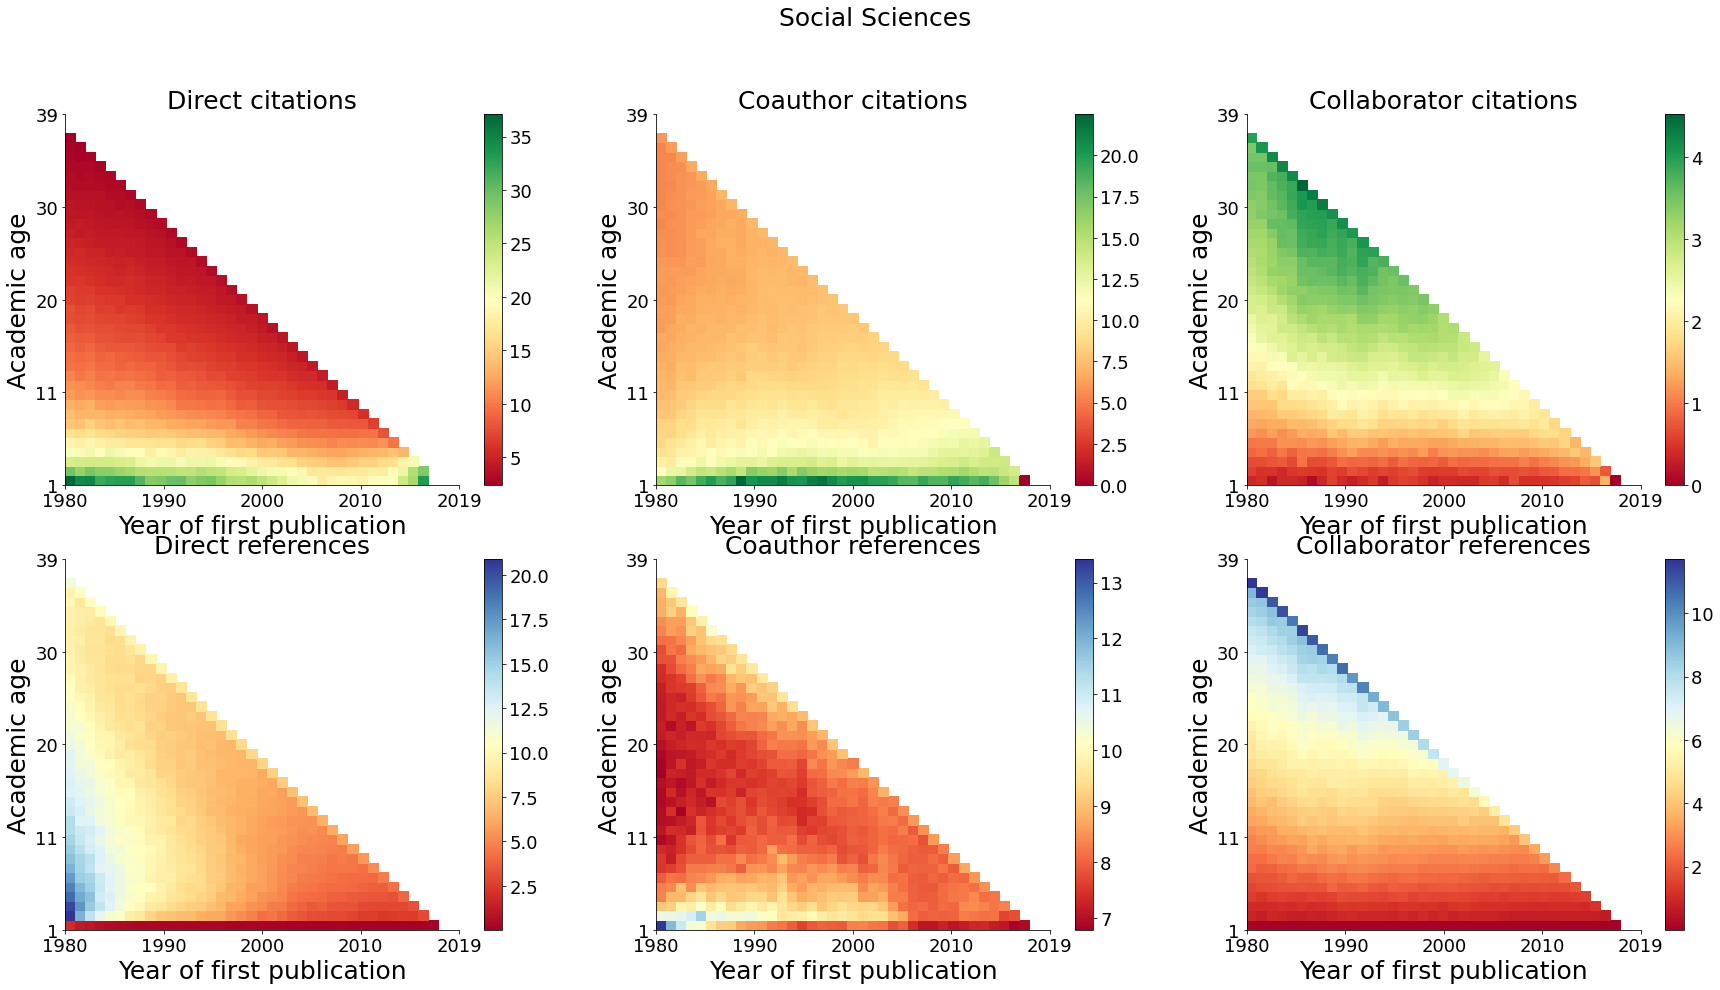

In [18]:

plt.figure(figsize=(30,15))
n_yt = 5
n_xt = 5
xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
#yticks_lab = np.round(yticks_lab,1)
xticks = np.linspace(0,nb_years,n_xt)
yticks = np.linspace(0,nb_years,n_yt)


ax = plt.subplot(231)
mat = stats_cits['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,2:nb_years-1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct citations' ,fontsize=25)

ax = plt.subplot(232)
mat = stats_cits['co_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,2:nb_years]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Coauthor citations',fontsize=25)

ax = plt.subplot(233)
mat = stats_cits['self_net_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,2:nb_years]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Collaborator citations',fontsize=25)

ax = plt.subplot(234)
mat = stats_refs['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,2:nb_years]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct references' ,fontsize=25)

#Show var
ax = plt.subplot(235)
mat = stats_refs['co_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,2:nb_years]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Coauthor references',fontsize=25)

ax = plt.subplot(236)
mat = stats_refs['self_net_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,2:nb_years]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Collaborator references',fontsize=25)

plt.suptitle(group, fontsize=25)
plt.show()

In [47]:
diag = 0
ax = plt.subplot(231)
mat = stats_cits['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
np.nanstd(mat)

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


9.400255852192739

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in greater


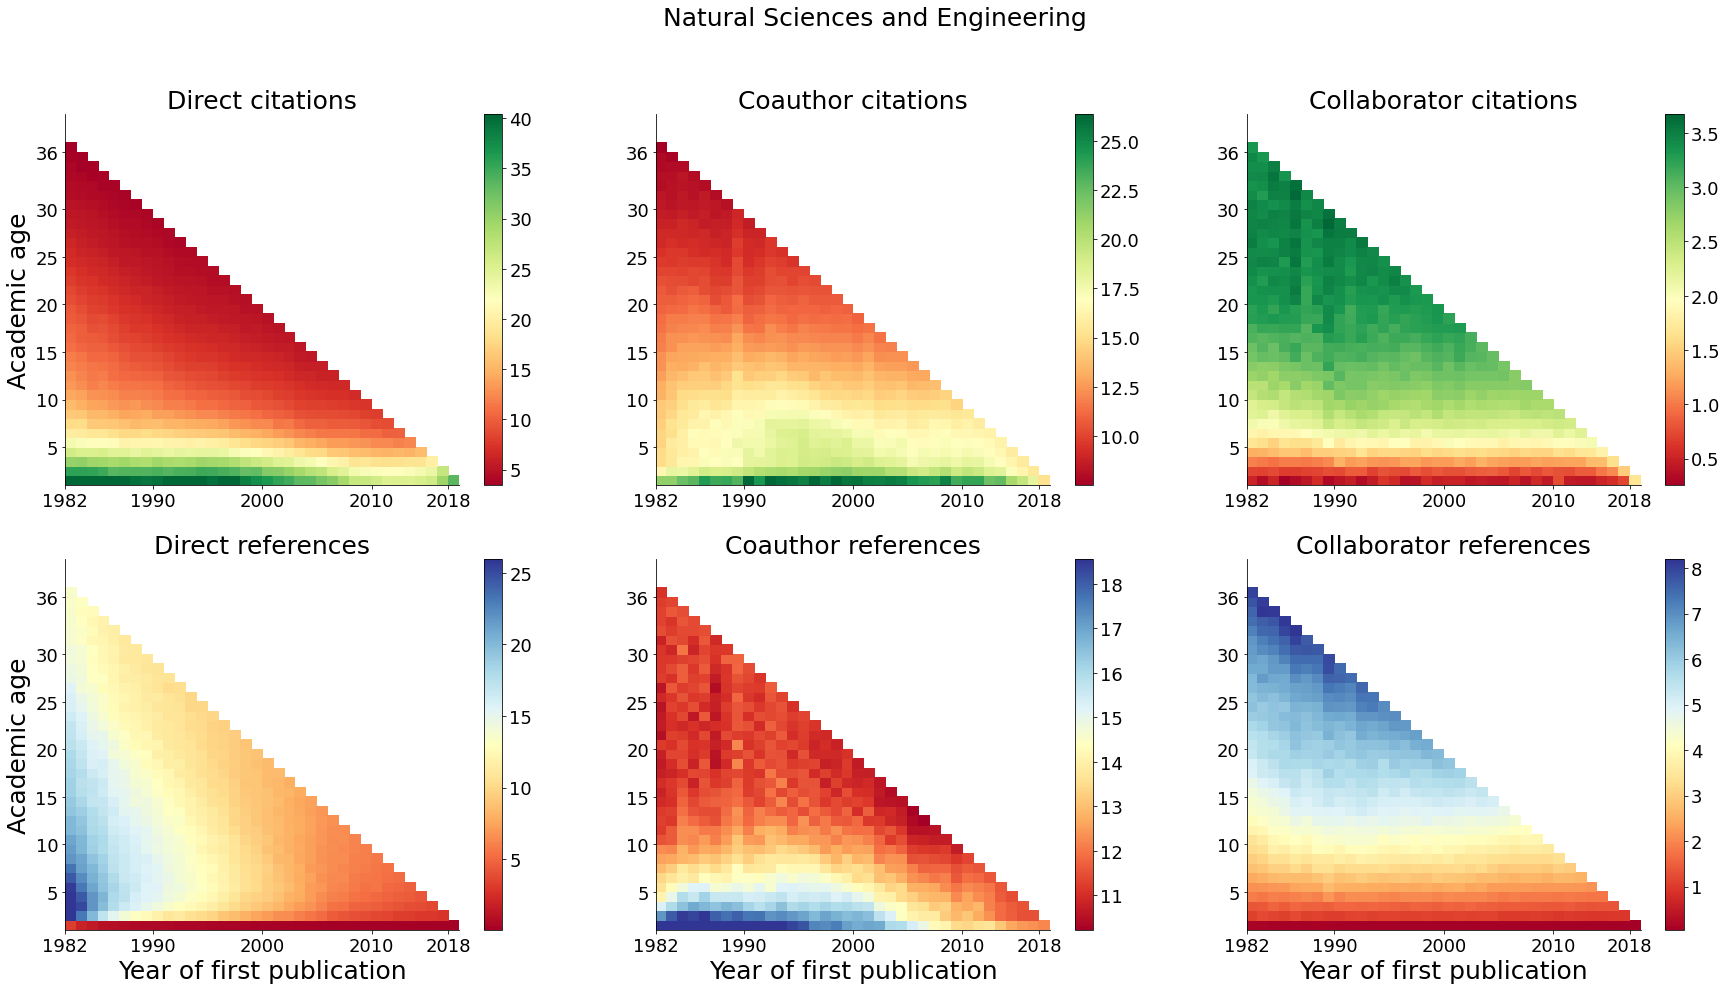

In [53]:
max_z = 3


plt.figure(figsize=(30,15))
n_yt = 5
n_xt = 5
xticks_lab = [1982,1990,2000,2010,2018]
#xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
#yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
#yticks_lab = [10,20,30,36]
yticks_lab = [5,10,15,20,25,30,36]
#xticks = np.linspace(0,nb_years,n_xt)
xticks = [0,8,18,28,35]
yticks = np.array(yticks_lab)-1
#yticks = np.linspace(0,nb_years,n_yt)

diag = 0
ax = plt.subplot(231)
mat = stats_cits['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
#plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct citations' ,fontsize=25)

ax = plt.subplot(232)
mat = stats_cits['co_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
#plt.ylabel('Academic age',fontsize=25)
#plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Coauthor citations',fontsize=25)

ax = plt.subplot(233)
mat = stats_cits['self_net_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
#plt.ylabel('Academic age',fontsize=25)
#plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Collaborator citations',fontsize=25)

ax = plt.subplot(234)
mat = stats_refs['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct references' ,fontsize=25)

#Show var
ax = plt.subplot(235)
mat = stats_refs['co_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
#plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Coauthor references',fontsize=25)

ax = plt.subplot(236)
mat = stats_refs['self_net_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], diag)] = np.nan
mat = np.rot90(mat, 1)
mat = mat[:,age_range[0]:age_range[1]]
mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
#plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Collaborator references',fontsize=25)

plt.suptitle(group, fontsize=25)
plt.show()

In [16]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}

    for type_cit in types_cit:
        for disc in disc_group:
            load_ref = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            nb_auts = load_cit.shape[0]
            nb_pubs = np.array([authors_info[authors_disc_idx_raw[disc][x]][2] for x in range(nb_auts)])

            no_min_pub = np.where(nb_pubs<min_pubs)[0]
            load_cit[no_min_pub,:] = 0 

            if type_cit in arrays_cits: 
                arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
                arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],load_ref],axis=0)
            else:
                arrays_cits[type_cit] = load_cit
                arrays_refs[type_cit] = load_ref

    for disc in disc_group:
        load_ref = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        load_cit = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        nb_auts = load_cit.shape[0]
        nb_pubs = np.array([authors_info[authors_disc_idx_raw[disc][x]][2] for x in range(nb_auts)])
        no_min_pub = np.where(nb_pubs<min_pubs)[0]
        load_cit[no_min_pub,:] = 0 
        if 'self_net' in arrays_cits:
            arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                                   load_cit],axis=0)
            arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                                   load_ref],axis=0)
        else:
            arrays_cits['self_net'] = load_cit
            arrays_refs['self_net'] = load_ref

    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    total_refs_cumul = np.sum(total_refs,axis=1)
    total_cits_cumul = np.sum(total_cits,axis=1)
    rows_refs = np.where(total_refs_cumul)[0]
    rows_cits = np.where(total_cits_cumul)[0]

    plot_types = ['self','co','self_net']
    stats_refs = {}
    stats_cits = {}

    keys = list(authors_groups_idx[group])
    keys.sort()
    auth_idx_disc = [authors_groups_idx[group][idx] for idx in keys]
    year_start = [authors_info[ID][1] for ID in auth_idx_disc]

    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
        arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

        idx_cits = total_cits.nonzero()
        idx_refs = total_refs.nonzero()
        arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
        arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

        count_cits = np.count_nonzero(total_cits,axis=1)
        idx_count_cits = np.where(count_cits)[0]
        #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_cits)
        for j in range(nb_authors):
            idx_author = idx_count_cits[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_cits[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1    

        stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_cits = total.nonzero()
        stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])

        count_refs = np.count_nonzero(total_refs,axis=1)
        idx_count_refs = np.where(count_refs)[0]
        #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_refs)

        for j in range(nb_authors):
            idx_author = idx_count_refs[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_refs[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1  

        stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_refs = total.nonzero()
        stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])




    max_z = 3
    plt.figure(figsize=(30,15))
    n_yt = 5
    n_xt = 5
    xticks_lab = [1982,1990,2000,2010,2018]
    #xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
    #yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
    #yticks_lab = [10,20,30,36]
    yticks_lab = [5,10,15,20,25,30,36]
    #xticks = np.linspace(0,nb_years,n_xt)
    xticks = [0,8,18,28,35]
    yticks = np.array(yticks_lab)-1
    #yticks = np.linspace(0,nb_years,n_yt)

    diag = 0
    ax = plt.subplot(231)
    mat = stats_cits['self_perc_year']
    mat = np.rot90(mat, -1)
    mat[np.tril_indices(mat.shape[0], diag)] = np.nan
    mat = np.rot90(mat, 1)
    mat = mat[:,age_range[0]:age_range[1]]
    mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
    mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.pcolor(mat,cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    #plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Direct citations' ,fontsize=25)

    ax = plt.subplot(232)
    mat = stats_cits['co_perc_year']
    mat = np.rot90(mat, -1)
    mat[np.tril_indices(mat.shape[0], diag)] = np.nan
    mat = np.rot90(mat, 1)
    mat = mat[:,age_range[0]:age_range[1]]
    mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
    mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.pcolor(mat,cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    #plt.ylabel('Academic age',fontsize=25)
    #plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Coauthor citations',fontsize=25)

    ax = plt.subplot(233)
    mat = stats_cits['self_net_perc_year']
    mat = np.rot90(mat, -1)
    mat[np.tril_indices(mat.shape[0], diag)] = np.nan
    mat = np.rot90(mat, 1)
    mat = mat[:,age_range[0]:age_range[1]]
    mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
    mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.pcolor(mat,cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    #plt.ylabel('Academic age',fontsize=25)
    #plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Collaborator citations',fontsize=25)

    ax = plt.subplot(234)
    mat = stats_refs['self_perc_year']
    mat = np.rot90(mat, -1)
    mat[np.tril_indices(mat.shape[0], diag)] = np.nan
    mat = np.rot90(mat, 1)
    mat = mat[:,age_range[0]:age_range[1]]
    mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
    mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.pcolor(mat,cmap='RdYlBu')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Direct references' ,fontsize=25)

    #Show var
    ax = plt.subplot(235)
    mat = stats_refs['co_perc_year']
    mat = np.rot90(mat, -1)
    mat[np.tril_indices(mat.shape[0], diag)] = np.nan
    mat = np.rot90(mat, 1)
    mat = mat[:,age_range[0]:age_range[1]]
    mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
    mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.pcolor(mat,cmap='RdYlBu')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    #plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Coauthor references',fontsize=25)

    ax = plt.subplot(236)
    mat = stats_refs['self_net_perc_year']
    mat = np.rot90(mat, -1)
    mat[np.tril_indices(mat.shape[0], diag)] = np.nan
    mat = np.rot90(mat, 1)
    mat = mat[:,age_range[0]:age_range[1]]
    mat_sd = (mat-np.nanmean(mat))/np.nanstd(mat)
    mat[np.where(np.abs(mat_sd)>max_z)] = np.nanstd(mat)*max_z+np.nanmean(mat)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.pcolor(mat,cmap='RdYlBu')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    #plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=18)
    plt.title('Collaborator references',fontsize=25)

    plt.suptitle(group, fontsize=25)
    
    out_path = path+'results/fig_matrix_norm_perc_network/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '.png')
    plt.savefig(out_path + group + '.svg')
    plt.close()
    
    plt.figure(figsize=(12,8))
    for j in plot_years:
        xaxis = np.arange(min_year,max_year-j)
        nb_x = len(xaxis)
        idx_year = plot_years[j]
        plt.subplot(2,3,j+1)
        plt.plot(xaxis,stats_cits['self_perc_year'][idx_year,:nb_x],'r',label='% direct cits')
        plt.plot(xaxis,stats_cits['co_perc_year'][idx_year,:nb_x],'r--',label='% indirect cits')
        plt.plot(xaxis,stats_cits['self_net_perc_year'][idx_year,:nb_x],'r-.',label='% network cits')
        plt.plot(xaxis,stats_refs['self_perc_year'][idx_year,:nb_x],'g',label='% direct refs')
        plt.plot(xaxis,stats_refs['co_perc_year'][idx_year,:nb_x],'g--',label='% indirect refs')
        plt.plot(xaxis,stats_refs['self_net_perc_year'][idx_year,:nb_x],'g-.',label='% network refs')
        plt.xlim([min_year,max_year])
        plt.title('Academic age: ' + str(idx_year+1))
        if j == 0:
            plt.legend()

    out_path = path+'results/fig_cross_section_network/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + group + '.png')
    plt.savefig(out_path + group + '.svg')
    plt.close()

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:233: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in greater
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:152: RuntimeWarnin

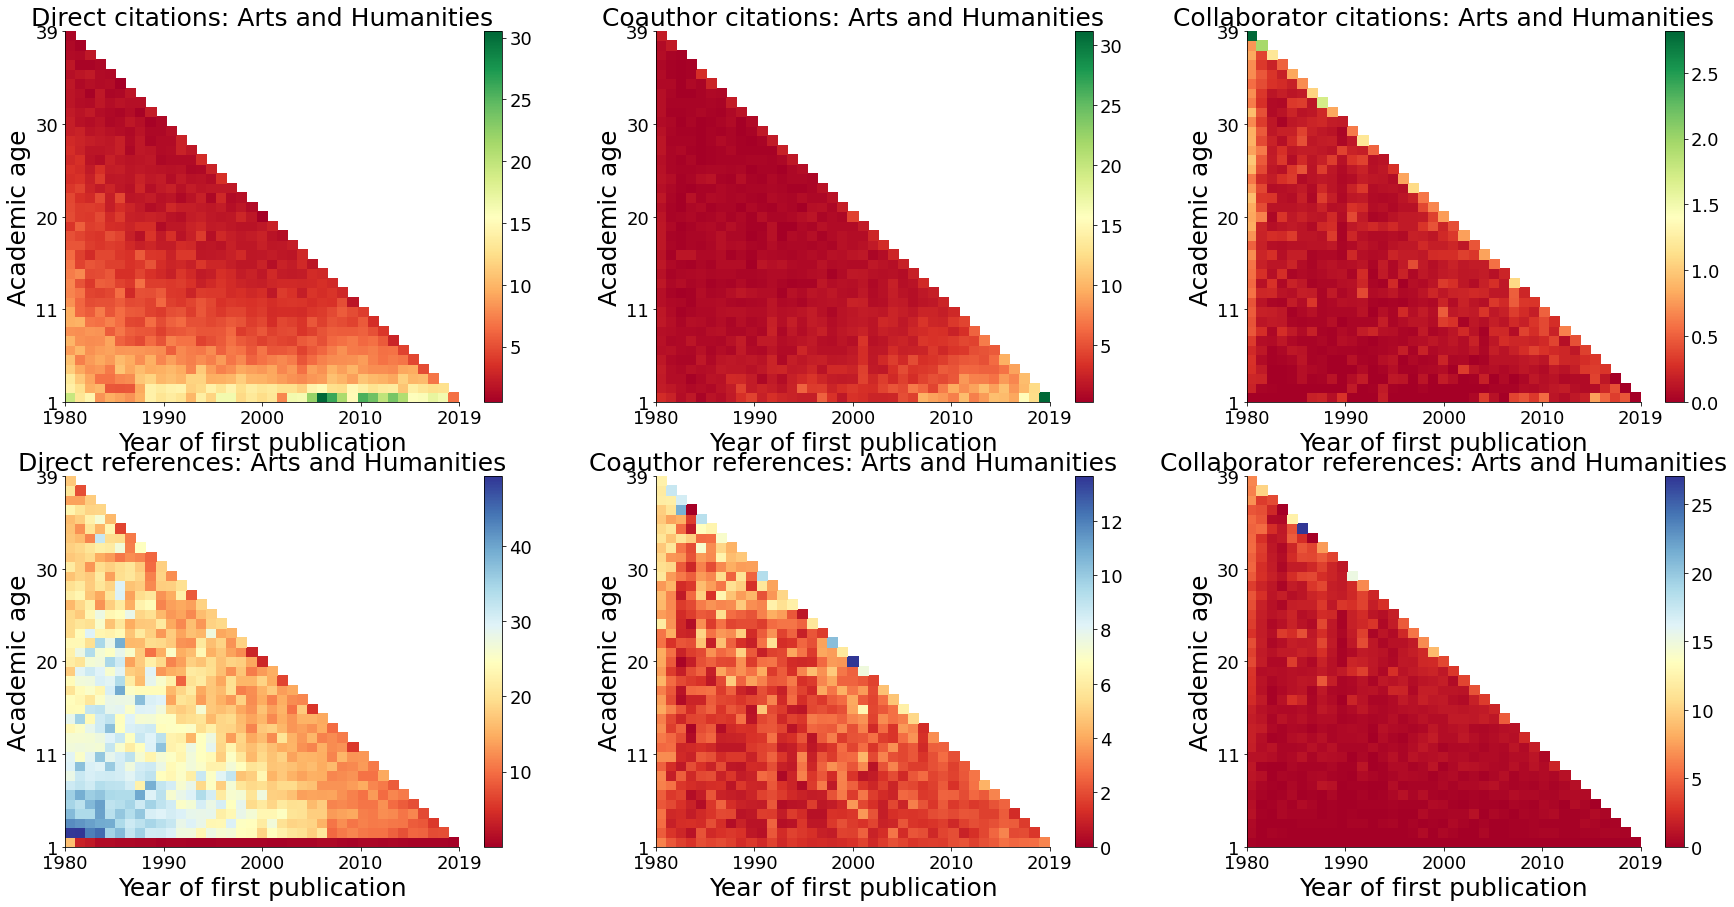

In [34]:
i=0
group = group_names[i]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}

for type_cit in types_cit:
    for disc in disc_group:
        if type_cit in arrays_cits:
            arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],
                                                   sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()],axis=0)
            arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],
                                                   sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()],axis=0)
        else:
            arrays_cits[type_cit] = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            arrays_refs[type_cit] = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()

for disc in disc_group:
    if 'self_net' in arrays_cits:
        arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                               sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()],axis=0)
        arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                               sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()],axis=0)
    else:
        arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()


total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
total_refs_cumul = np.sum(total_refs,axis=1)
total_cits_cumul = np.sum(total_cits,axis=1)
rows_refs = np.where(total_refs_cumul)[0]
rows_cits = np.where(total_cits_cumul)[0]

plot_types = ['self','co','self_net']
stats_refs = {}
stats_cits = {}

keys = list(authors_groups_idx[group])
keys.sort()
auth_idx_disc = [authors_groups_idx[group][idx] for idx in keys]
year_start = [authors_info[ID][1] for ID in auth_idx_disc]

for type_cit in plot_types:
    arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
    arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

    idx_cits = total_cits.nonzero()
    idx_refs = total_refs.nonzero()
    arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
    arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

    count_cits = np.count_nonzero(total_cits,axis=1)
    idx_count_cits = np.where(count_cits)[0]
    #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    numerator = np.zeros((nb_years,nb_years))
    total = np.zeros((nb_years,nb_years))
    nb_authors = len(idx_count_cits)
    for j in range(nb_authors):
        idx_author = idx_count_cits[j]
        year = year_start[idx_author]
        if year >= min_year and year < max_year:
            row_start = year - min_year
            row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
            numerator[:,row_start] += row
            row_has_count = total_cits[idx_author,:].nonzero()[1]
            total[row_has_count,row_start] += 1    

    stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    non_zero_cits = total.nonzero()
    stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])

    count_refs = np.count_nonzero(total_refs,axis=1)
    idx_count_refs = np.where(count_refs)[0]
    #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    numerator = np.zeros((nb_years,nb_years))
    total = np.zeros((nb_years,nb_years))
    nb_authors = len(idx_count_refs)

    for j in range(nb_authors):
        idx_author = idx_count_refs[j]
        year = year_start[idx_author]
        if year >= min_year and year < max_year:
            row_start = year - min_year
            row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
            numerator[:,row_start] += row
            row_has_count = total_refs[idx_author,:].nonzero()[1]
            total[row_has_count,row_start] += 1  

    stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    non_zero_refs = total.nonzero()
    stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])




plt.figure(figsize=(30,15))
n_yt = 5
n_xt = 5
xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
#yticks_lab = np.round(yticks_lab,1)
xticks = np.linspace(0,nb_years,n_xt)
yticks = np.linspace(0,nb_years,n_yt)


ax = plt.subplot(231)
mat = stats_cits['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct citations: ' + group,fontsize=25)

ax = plt.subplot(232)
mat = stats_cits['co_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Coauthor citations: ' + group,fontsize=25)

ax = plt.subplot(233)
mat = stats_cits['self_net_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Collaborator citations: ' + group,fontsize=25)

ax = plt.subplot(234)
mat = stats_refs['self_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct references: ' + group,fontsize=25)

#Show var
ax = plt.subplot(235)
mat = stats_refs['co_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Coauthor references: ' + group,fontsize=25)

ax = plt.subplot(236)
mat = stats_refs['self_net_perc_year']
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.pcolor(mat,cmap='RdYlBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Collaborator references: ' + group,fontsize=25)
plt.show()

In [28]:
stats_cits['self_perc_year'][rm_idx].shape

(780,)

In [ ]:
plt.figure(figsize=(30,12))
n_yt = 5
n_xt = 5
xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
#yticks_lab = np.round(yticks_lab,1)
xticks = np.linspace(0,nb_years,n_xt)
yticks = np.linspace(0,nb_years,n_yt)


mat = stats_refs['self_perc_year'].copy()
mat = np.rot90(mat, 1)
mat[np.triu_indices(mat.shape[0], 1)] = np.nan
mat = np.rot90(mat, 1)




plt.subplot(231)


plt.pcolor(stats_cits['self_perc_year'],cmap='hot')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 

plt.pcolor(mat,cmap='bwr')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 

plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct citations: ' + group,fontsize=25)
plt.show()

In [16]:
i=0
group = group_names[i]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}

for type_cit in types_cit:
    for disc in disc_group:
        if type_cit in arrays_cits:
            arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],
                                                   sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()],axis=0)
            arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],
                                                   sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()],axis=0)
        else:
            arrays_cits[type_cit] = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
            arrays_refs[type_cit] = sparse.load_npz('{}/arrays/references_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()

for disc in disc_group:
    if 'self_net' in arrays_cits:
        arrays_cits['self_net'] = np.concatenate([arrays_cits['self_net'],
                                               sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()],axis=0)
        arrays_refs['self_net'] = np.concatenate([arrays_refs['self_net'],
                                               sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()],axis=0)
    else:
        arrays_cits['self_net'] = sparse.load_npz('{}/arrays/citations_self_{}_network_array_norm.npz'.format(path,disc)).todense()
        arrays_refs['self_net'] = sparse.load_npz('{}/arrays/references_self_{}_network_array_norm.npz'.format(path,disc)).todense()


total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
total_refs_cumul = np.sum(total_refs,axis=1)
total_cits_cumul = np.sum(total_cits,axis=1)
rows_refs = np.where(total_refs_cumul)[0]
rows_cits = np.where(total_cits_cumul)[0]

plot_types = ['self','co','self_net']
stats_refs = {}
stats_cits = {}

keys = list(authors_groups_idx[group])
keys.sort()
auth_idx_disc = [authors_groups_idx[group][idx] for idx in keys]
year_start = [authors_info[ID][1] for ID in auth_idx_disc]

for type_cit in plot_types:
    arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
    arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

    idx_cits = total_cits.nonzero()
    idx_refs = total_refs.nonzero()
    arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
    arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

    count_cits = np.count_nonzero(total_cits,axis=1)
    idx_count_cits = np.where(count_cits)[0]
    #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    numerator = np.zeros((nb_years,nb_years))
    total = np.zeros((nb_years,nb_years))
    nb_authors = len(idx_count_cits)
    for j in range(nb_authors):
        idx_author = idx_count_cits[j]
        year = year_start[idx_author]
        if year >= min_year and year < max_year:
            row_start = year - min_year
            row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
            numerator[:,row_start] += row
            row_has_count = total_cits[idx_author,:].nonzero()[1]
            total[row_has_count,row_start] += 1    

    stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    non_zero_cits = total.nonzero()
    stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])

    count_refs = np.count_nonzero(total_refs,axis=1)
    idx_count_refs = np.where(count_refs)[0]
    #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    numerator = np.zeros((nb_years,nb_years))
    total = np.zeros((nb_years,nb_years))
    nb_authors = len(idx_count_refs)

    for j in range(nb_authors):
        idx_author = idx_count_refs[j]
        year = year_start[idx_author]
        if year >= min_year and year < max_year:
            row_start = year - min_year
            row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
            numerator[:,row_start] += row
            row_has_count = total_refs[idx_author,:].nonzero()[1]
            total[row_has_count,row_start] += 1  

    stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
    non_zero_refs = total.nonzero()
    stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])


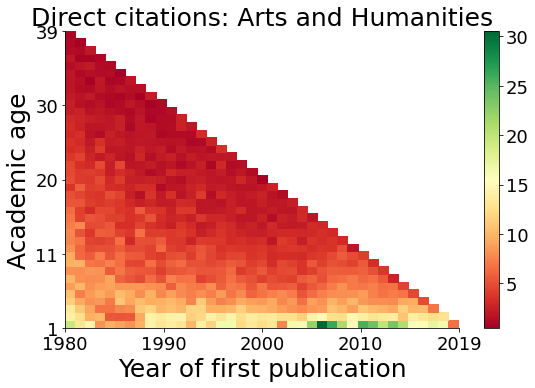

In [33]:
plt.figure(figsize=(30,12))
n_yt = 5
n_xt = 5
xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
#yticks_lab = np.round(yticks_lab,1)
xticks = np.linspace(0,nb_years,n_xt)
yticks = np.linspace(0,nb_years,n_yt)


mat = stats_cits['self_perc_year'].copy()
mat = np.rot90(mat, -1)
mat[np.tril_indices(mat.shape[0], -1)] = np.nan
mat = np.rot90(mat, 1)
ax = plt.subplot(231)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.pcolor(mat,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 

plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct citations: ' + group,fontsize=25)
plt.show()

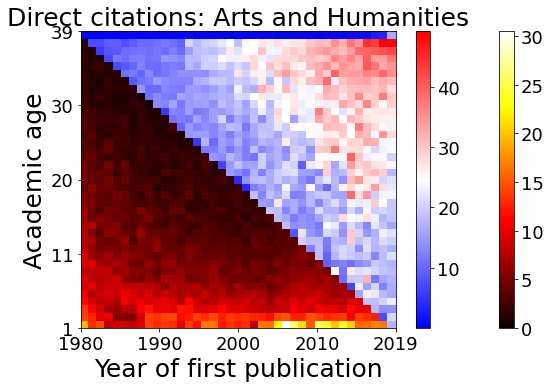

In [59]:
plt.figure(figsize=(30,12))
n_yt = 5
n_xt = 5
xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
#yticks_lab = np.round(yticks_lab,1)
xticks = np.linspace(0,nb_years,n_xt)
yticks = np.linspace(0,nb_years,n_yt)


mat = stats_refs['self_perc_year'].copy()
mat = np.rot90(mat, 1)
mat[np.triu_indices(mat.shape[0], 1)] = np.nan
mat = np.rot90(mat, 1)




plt.subplot(231)


plt.pcolor(stats_cits['self_perc_year'],cmap='hot')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 

plt.pcolor(mat,cmap='bwr')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 

plt.xticks(xticks,xticks_lab)
plt.yticks(yticks,yticks_lab)
plt.ylabel('Academic age',fontsize=25)
plt.xlabel('Year of first publication',fontsize=25)
plt.tick_params(labelsize=18)
plt.title('Direct citations: ' + group,fontsize=25)
plt.show()

In [14]:
plot_years = [0,1,2,3,4,5]

### Get raw count of citations

##### By disc

In [ ]:
for i in range(nb_disciplines):
    disc = list_disciplines[i]
    arrays_cits = {}
    for type_cit in types_cit:
        arrays_cits[type_cit] = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm.npz'.format(path,type_cit,disc)).todense()
      
    
    active = np.zeros(arrays_cits[type_cit].shape)
    last_nz = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
    nb_cit = np.sum(arrays_cits[type_cit],axis=1)
    for j in range(active.shape[0]):
        if nb_cit[j] > 0:
            last_idx = np.asarray(last_nz[j])[0][0]
            active[j,:last_idx+1] = 1
    nb_active = np.sum(active,axis=0)
    plot_types = ['self','co','others']
    stats_cits = {}    
        
        
        
    total_refs = arrays_refs['self'] + arrays_refs['co'] + arrays_refs['others'] 
    total_cits =  arrays_cits['self'] + arrays_cits['co'] + arrays_cits['others'] 
    total_refs_cumul = np.sum(total_refs,axis=1)
    total_cits_cumul = np.sum(total_cits,axis=1)
    rows_refs = np.where(total_refs_cumul)[0]
    rows_cits = np.where(total_cits_cumul)[0]

    plot_types = ['self','co']
    stats_refs = {}
    stats_cits = {}

    keys = list(authors_disc_idx[disc])
    keys.sort()
    auth_idx_disc = [authors_disc_idx[disc][idx] for idx in keys]
    year_start = [authors_info[ID][1] for ID in auth_idx_disc]

    for type_cit in plot_types:
        arrays_refs[type_cit + '_perc_year'] = np.zeros(arrays_refs[type_cit].shape) 
        arrays_cits[type_cit + '_perc_year'] = np.zeros(arrays_cits[type_cit].shape) 

        idx_cits = total_cits.nonzero()
        idx_refs = total_refs.nonzero()
        arrays_refs[type_cit + '_perc_year'][idx_refs] = (arrays_refs[type_cit][idx_refs]/total_refs[idx_refs])*100
        arrays_cits[type_cit + '_perc_year'][idx_cits] = (arrays_cits[type_cit][idx_cits]/total_cits[idx_cits])*100

        count_cits = np.count_nonzero(total_cits,axis=1)
        idx_count_cits = np.where(count_cits)[0]
        #stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_cits)
        for j in range(nb_authors):
            idx_author = idx_count_cits[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_cits[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_cits[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1    


        stats_cits[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_cits = total.nonzero()
        stats_cits[type_cit + '_perc_year'][non_zero_cits] = np.divide(numerator[non_zero_cits],total[non_zero_cits])

        count_refs = np.count_nonzero(total_refs,axis=1)
        idx_count_refs = np.where(count_refs)[0]
        #stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        numerator = np.zeros((nb_years,nb_years))
        total = np.zeros((nb_years,nb_years))
        nb_authors = len(idx_count_refs)
        
        for j in range(nb_authors):
            idx_author = idx_count_refs[j]
            year = year_start[idx_author]
            if year >= min_year and year < max_year:
                row_start = year - min_year
                row = arrays_refs[type_cit + '_perc_year'][idx_author,:]
                numerator[:,row_start] += row
                row_has_count = total_refs[idx_author,:].nonzero()[1]
                total[row_has_count,row_start] += 1  

        stats_refs[type_cit + '_perc_year'] = np.zeros((nb_years,nb_years))
        non_zero_refs = total.nonzero()
        stats_refs[type_cit + '_perc_year'][non_zero_refs] = np.divide(numerator[non_zero_refs],total[non_zero_refs])





    plt.figure(figsize=(20,15))

    n_yt = 5
    n_xt = 5
    xticks_lab = np.ceil(np.linspace(min_year,max_year,n_xt)).astype(np.int)
    yticks_lab = np.ceil(np.linspace(1,nb_years,n_yt)).astype(np.int)#[np.format_float_scientific(x) for x in np.round(np.linspace(coef[0],coef[-1],n_yt),4)]
    #yticks_lab = np.round(yticks_lab,1)
    xticks = np.linspace(0,nb_years,n_xt)
    yticks = np.linspace(0,nb_years,n_yt)
    
    plt.subplot(221)
    plt.pcolor(stats_cits['self_perc_year'],cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=20)
    plt.title('Direct citations: ' + disc,fontsize=25)


    #Show var
    plt.subplot(222)
    plt.pcolor(stats_refs['self_perc_year'],cmap='bwr')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=20)
    plt.title('Direct references: ' + disc,fontsize=25)
    
    plt.subplot(223)
    plt.pcolor(stats_cits['co_perc_year'],cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=20)
    plt.title('Indirect citations: ' + disc,fontsize=25)


    #Show var
    plt.subplot(224)
    plt.pcolor(stats_refs['co_perc_year'],cmap='bwr')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20) 
    plt.xticks(xticks,xticks_lab)
    plt.yticks(yticks,yticks_lab)
    plt.ylabel('Academic age',fontsize=25)
    plt.xlabel('Year of first publication',fontsize=25)
    plt.tick_params(labelsize=20)
    plt.title('Indirect references: ' + disc,fontsize=25)
    
    
    
    out_path = path+'results/fig_matrix_norm_perc/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + disc + '.png')
    plt.close()
    
    plt.figure(figsize=(12,8))
    for j in plot_years:
        xaxis = np.arange(min_year,max_year-j)
        nb_x = len(xaxis)
        idx_year = plot_years[j]
        plt.subplot(2,3,j+1)
        plt.plot(xaxis,stats_cits['self_perc_year'][idx_year,:nb_x],'r',label='% direct cits')
        plt.plot(xaxis,stats_cits['co_perc_year'][idx_year,:nb_x],'r--',label='% indirect cits')
        plt.plot(xaxis,stats_refs['self_perc_year'][idx_year,:nb_x],'g',label='% direct refs')
        plt.plot(xaxis,stats_refs['co_perc_year'][idx_year,:nb_x],'g--',label='% indirect cits')
        plt.xlim([min_year,max_year])
        plt.title('Academic age: ' + str(idx_year+1))
        if j == 0:
            plt.legend()

    out_path = path+'results/fig_cross_section/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + disc + '.png')
    plt.close()
